In [1]:
import random
from collections import deque
from dataclasses import dataclass

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from skimage import transform
from vizdoom import DoomGame

In [2]:
ACTION_SIZE = 3
FRAME_STACK_SIZE = 4
STATE_SIZE = (4, 84, 84)

TOTAL_EPISODES = 10000
LEARNING_RATE = 0.0002
BATCH_SIZE = 64
MAX_STEPS = 100
DISCOUNT_RATE = 0.95

EXPLORATION_RATE_MAX = 1.0
EXPLORATION_RATE_MIN = 0.01
EXPLORATION_RATE_DECAY = 0.0002

INITIAL_MEMORY_SIZE = 10_000
MEMORY_SIZE = 100_000

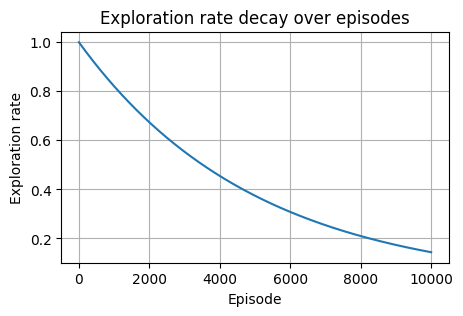

In [3]:
episodes = np.arange(TOTAL_EPISODES)
exploration_rates = EXPLORATION_RATE_MIN + (
    EXPLORATION_RATE_MAX - EXPLORATION_RATE_MIN
) * np.exp(-EXPLORATION_RATE_DECAY * episodes)

plt.figure(figsize=(5, 3))
plt.plot(episodes, exploration_rates)
plt.title("Exploration rate decay over episodes")
plt.xlabel("Episode")
plt.ylabel("Exploration rate")
plt.grid(True)
plt.show()

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def create_environment(set_window_visible=False):
    game = DoomGame()
    game.load_config("basic.cfg")
    game.set_doom_scenario_path("basic.wad")
    game.set_window_visible(set_window_visible)
    game.init()
    left = [1, 0, 0]
    right = [0, 1, 0]
    shoot = [0, 0, 1]
    actions = torch.LongTensor([left, right, shoot])
    return game, actions

In [ ]:
game, possible_actions = create_environment()
game.new_episode()
frame = game.get_state().screen_buffer
game.close()

In [7]:
def preprocess_frame(frame):
    preprocessed_frame = np.copy(frame)
    preprocessed_frame = preprocessed_frame.mean(axis=0)
    preprocessed_frame = preprocessed_frame[30:-20, 30:-30]
    preprocessed_frame /= 255
    preprocessed_frame = transform.resize(preprocessed_frame, [84, 84])
    return preprocessed_frame

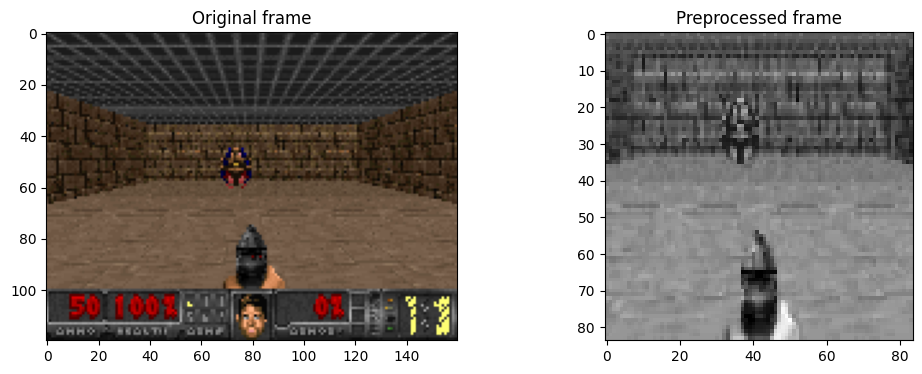

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].imshow(frame.transpose(1, 2, 0))
ax[0].set_title("Original frame")
ax[1].imshow(preprocess_frame(frame), cmap="gray")
ax[1].set_title("Preprocessed frame")
plt.show()

In [9]:
class FrameStack:
    def __init__(self, stack_size=FRAME_STACK_SIZE):
        self.stack_size = stack_size
        self.reset()

    def reset(self):
        self.frames = deque(
            [np.zeros((84, 84), dtype=np.uint8) for _ in range(self.stack_size)],
            maxlen=self.stack_size,
        )

    def stack(self, frame, is_new_episode=False):
        if is_new_episode:
            self.reset()
            for _ in range(self.stack_size):
                self.frames.append(frame)
        else:
            self.frames.append(frame)

        return np.stack(self.frames, axis=0)

In [10]:
class DeepQNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(DeepQNetwork, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=state_size[0], out_channels=32, kernel_size=8, stride=4
        )
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(
            in_channels=64, out_channels=128, kernel_size=4, stride=2
        )
        # 4x84x84 -> conv1(84x84) = 32x20x20 -> conv2(20x20) = 64x9x9 -> conv3(9x9) = 128x3x3 = 1152
        self.fc1 = nn.Linear(in_features=1152, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=action_size)
        self.elu = nn.ELU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.elu(x)
        x = self.conv2(x)
        x = self.elu(x)
        x = self.conv3(x)
        x = self.elu(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.elu(x)
        x = self.fc2(x)
        return x

In [ ]:
class ExperienceBuffer:
    @dataclass(frozen=True)
    class Experience:
        state: np.ndarray
        action: list[int]
        reward: int
        next_state: np.ndarray
        is_episode_finished: bool

    def __init__(self, memory_size: int, frame_stack: FrameStack):
        self.experience_buffer = deque(maxlen=memory_size)
        self.frame_stack = frame_stack
        self.initialize_experience_buffer()

    def add(self, experience):
        self.experience_buffer.append(experience)

    def sample(self, batch_size):
        return random.sample(self.experience_buffer, batch_size)

    def initialize_experience_buffer(self):
        game, possible_actions = create_environment()

        while len(self.experience_buffer) < INITIAL_MEMORY_SIZE:
            game.new_episode()
            frame = preprocess_frame(game.get_state().screen_buffer)
            state = self.frame_stack.stack(frame, True)

            while not game.is_episode_finished():
                action = random.choice(possible_actions.tolist())
                reward = game.make_action(action)
                is_episode_finished = game.is_episode_finished()

                if is_episode_finished:
                    next_state = np.zeros(state.shape)
                else:
                    frame = preprocess_frame(game.get_state().screen_buffer)
                    next_state = self.frame_stack.stack(frame)

                self.add(
                    ExperienceBuffer.Experience(
                        state, action, reward, next_state, is_episode_finished
                    )
                )
                state = next_state

        game.close()

In [12]:
def predict_action(model: nn.Module, state, episode, possible_actions):
    exploration_probability = EXPLORATION_RATE_MIN + (
        EXPLORATION_RATE_MAX - EXPLORATION_RATE_MIN
    ) * np.exp(-EXPLORATION_RATE_DECAY * episode)

    if np.random.rand() < exploration_probability:
        return random.choice(possible_actions.tolist())
    else:
        model.eval()
        with torch.no_grad():
            return possible_actions[
                model(
                    torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
                )
                .argmax(dim=1)
                .item()
            ].tolist()

In [ ]:
def train(
    model: nn.Module,
    optimizer: optim.Optimizer,
    criterion,
    experience_buffer: ExperienceBuffer,
    frame_stack: FrameStack,
):
    game, possible_actions = create_environment()
    rewards = []
    for episode in range(TOTAL_EPISODES):
        game.new_episode()
        state = frame_stack.stack(
            preprocess_frame(game.get_state().screen_buffer), is_new_episode=True
        )
        episode_rewards = 0
        for _ in range(MAX_STEPS):
            # Enviorment interaction phase
            action = predict_action(model, state, episode, possible_actions)
            reward = game.make_action(action)
            episode_rewards += reward
            is_episode_finished = game.is_episode_finished()

            if is_episode_finished:
                next_state = np.zeros(state.shape)
            else:
                next_state = frame_stack.stack(
                    preprocess_frame(game.get_state().screen_buffer)
                )

            experience_buffer.add(
                ExperienceBuffer.Experience(
                    state, action, reward, next_state, is_episode_finished
                )
            )
            state = next_state

            # Model training phase
            batch = experience_buffer.sample(BATCH_SIZE)
            states_batch = torch.tensor(
                np.array([exp.state for exp in batch]),
                dtype=torch.float32,
                device=device,
            )
            actions_batch = torch.tensor(
                np.array([exp.action for exp in batch]),
                dtype=torch.int64,
                device=device,
            )
            rewards_batch = torch.tensor(
                np.array([exp.reward for exp in batch]),
                dtype=torch.float32,
                device=device,
            )
            next_states_batch = torch.tensor(
                np.array([exp.next_state for exp in batch]),
                dtype=torch.float32,
                device=device,
            )
            is_episode_finished_batch = torch.tensor(
                np.array([exp.is_episode_finished for exp in batch]),
                dtype=torch.bool,
                device=device,
            )

            model.eval()
            with torch.no_grad():
                next_q_values = model(next_states_batch).max(dim=1).values
                target_q_values = (
                    rewards_batch
                    + DISCOUNT_RATE * next_q_values * ~is_episode_finished_batch
                )

            model.train()
            optimizer.zero_grad()
            predicted_q_values = (
                model(states_batch)
                .gather(1, actions_batch.argmax(dim=1).unsqueeze(1))
                .squeeze(1)
            )
            loss = criterion(predicted_q_values, target_q_values)
            loss.backward()
            optimizer.step()

            if is_episode_finished:
                break

        print(
            f"Episode: {episode + 1}, Total reward: {episode_rewards}, Loss: {loss.item()}, Exploration rate: {EXPLORATION_RATE_MIN + (EXPLORATION_RATE_MAX - EXPLORATION_RATE_MIN) * np.exp(-EXPLORATION_RATE_DECAY * episode)}"
        )

        rewards.append(episode_rewards)

    game.close()
    return rewards

In [14]:
model = DeepQNetwork(STATE_SIZE, ACTION_SIZE).to(device)
optimizer = torch.optim.RMSprop(model.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss()
rewards = train(
    model,
    optimizer,
    criterion,
    ExperienceBuffer(MEMORY_SIZE, FrameStack()),
    FrameStack(),
)

Episode: 1, Total reward: -125.0, Loss: 2.750206232070923, Exploration rate: 1.0
Episode: 2, Total reward: 69.0, Loss: 1.8362679481506348, Exploration rate: 0.9998020197986801
Episode: 3, Total reward: 95.0, Loss: 2.3391547203063965, Exploration rate: 0.999604079189441
Episode: 4, Total reward: 94.0, Loss: 313.25799560546875, Exploration rate: 0.9994061781643654
Episode: 5, Total reward: 91.0, Loss: 3.6147022247314453, Exploration rate: 0.9992083167155369
Episode: 6, Total reward: 67.0, Loss: 2.2578229904174805, Exploration rate: 0.9990104948350412
Episode: 7, Total reward: 80.0, Loss: 2.030588150024414, Exploration rate: 0.9988127125149655
Episode: 8, Total reward: 69.0, Loss: 314.89617919921875, Exploration rate: 0.9986149697473984
Episode: 9, Total reward: 68.0, Loss: 1.6281514167785645, Exploration rate: 0.9984172665244303
Episode: 10, Total reward: -130.0, Loss: 1.4080084562301636, Exploration rate: 0.9982196028381529
Episode: 11, Total reward: 93.0, Loss: 159.37966918945312, Expl

In [15]:
torch.save(model.state_dict(), "model.pth")

Text(0.5, 1.0, 'Cumulative rewards')

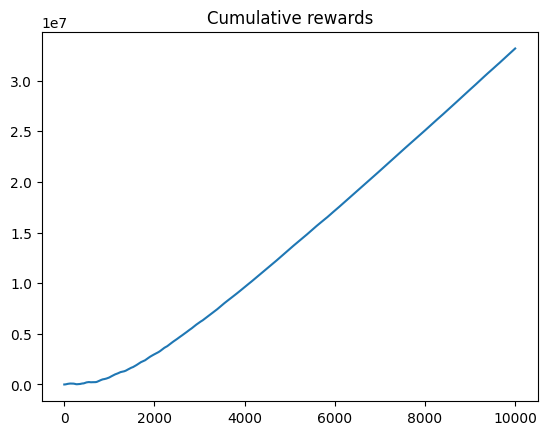

In [16]:
cumulative_rewards = np.cumsum(
    [np.sum(rewards[max(0, i - 50) : i]) for i in range(1, len(rewards) + 1)]
)
plt.plot(cumulative_rewards)
plt.title("Cumulative rewards")

In [ ]:
import time

frame_stack = FrameStack()
game, possible_actions = create_environment(set_window_visible=True)
game.new_episode()
frame = preprocess_frame(game.get_state().screen_buffer)
state = frame_stack.stack(frame, is_new_episode=True)
while True:
    action = predict_action(model, state, 0, possible_actions)
    game.make_action(action)
    if game.is_episode_finished():
        break
    frame = preprocess_frame(game.get_state().screen_buffer)
    state = frame_stack.stack(frame)
    time.sleep(0.1)
game.close()